<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

In [1]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt

In [3]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

    gsync = utils.GDriveSync()


try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

--2023-11-07 16:22:31--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2023-11-07 16:22:32 (38.3 MB/s) - ‘utils.py’ saved [4519/4519]

--2023-11-07 16:22:53--  https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StefOe/all-conv-pytorch/8545bb3ff7ac4410e52d8db930f0485074073ea9/allconv.py [following]
--2023-11-07 16:22:53--  https://raw.

## 2. Transformacion y carga de datos

In [4]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()

trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255


# Data normal (32x32)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_train8x8 = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


100%|██████████| 170498071/170498071 [00:02<00:00, 59533167.38it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


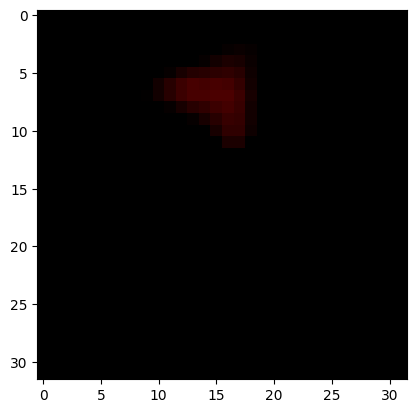

In [7]:
for batch_data, batch_labels in train_loader_blur:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

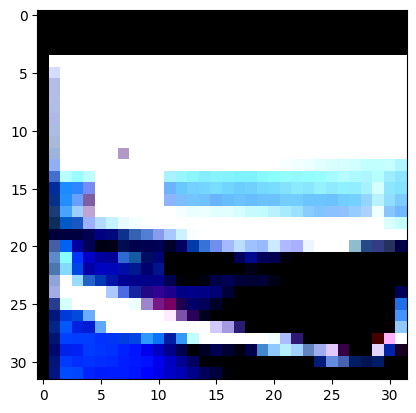

In [8]:
for batch_data, batch_labels in train_loader:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

## 3. Entrenamiento

In [9]:
model = AllConvNet(3)
if cuda:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[200, 250, 300], gamma=0.1)

In [10]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def blur_train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_blur):
        if cuda:
            data, target = data.cuda(), target.cuda() # Pasar la data a la GPU
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad() # Seteo en 0 los valores de los gradientes
        output = model(data) # Hago forward
        loss = criterion(output, target) # Se calcula la CrossEntropyLoss
        loss.backward()
        optimizer.step() # Actualización de los parámetros

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch, best_loss, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * correct /
            len(test_loader.dataset)))

    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss
        torch.save(model, "best.pt")
        if gsync_save:
            gsync.update_file_to_folder("best.pt")
    return best_loss, best_epoch

In [13]:
def begin_model(normal_init: int, blur_epochs: int, after_blur: int):
  # entrenar
  #   - normal por "normalinit" epocas,
  #   - con blur para "blurepochs" epocas mas,
  #   - de nuevo normal por "afterblur" epocas mas
  best_loss = float("inf")
  best_epoch = -1

  if normal_init<0 or blur_epochs<0 or after_blur<0:
    print('ERROR: parámetros inconsistentes')
  else:
    if normal_init == 0:

      print(f''' {'*'*30}
      Blurred image Training begin
                 {'*'*30}
      ''')

      for epoch in range(blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
                 {'*'*30}
      ''')

      for epoch in range(blur_epochs, blur_epochs + after_blur):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)


    elif normal_init != 0:

      for epoch in range(normal_init):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training begin
                 {'*'*30}
      ''')

      for epoch in range(normal_init, normal_init + blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
                 {'*'*30}
      ''')

      for epoch in range(normal_init+blur_epochs, normal_init+blur_epochs+after_blur):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

In [14]:
begin_model(normal_init=0, blur_epochs=40, after_blur=100)

 ******************************
      Blurred image Training begin
                 ******************************
      


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Epoch: 0 [0/50000 (0%)]	Loss: 2.306409
Train Epoch: 0 [3200/50000 (6%)]	Loss: 2.297758
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.303012
Train Epoch: 0 [9600/50000 (19%)]	Loss: 2.301070
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.305596
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.304634
Train Epoch: 0 [19200/50000 (38%)]	Loss: 2.302848
Train Epoch: 0 [22400/50000 (45%)]	Loss: 2.298956
Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.299377
Train Epoch: 0 [28800/50000 (58%)]	Loss: 2.299989
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.302301
Train Epoch: 0 [35200/50000 (70%)]	Loss: 2.299402
Train Epoch: 0 [38400/50000 (77%)]	Loss: 2.305706
Train Epoch: 0 [41600/50000 (83%)]	Loss: 2.305148
Train Epoch: 0 [44800/50000 (90%)]	Loss: 2.301135
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.304277

Test set: Average loss: 0.0187, Accuracy: 1002/10000 (10%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 98.71it/s]


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301537
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.303861
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.301304
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.304834
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.302206
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.299832
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.302661
Train Epoch: 1 [22400/50000 (45%)]	Loss: 2.299106
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.300681
Train Epoch: 1 [28800/50000 (58%)]	Loss: 2.301615
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.300578
Train Epoch: 1 [35200/50000 (70%)]	Loss: 2.302840
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.299453
Train Epoch: 1 [41600/50000 (83%)]	Loss: 2.303389
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.301854
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.303331

Test set: Average loss: 0.0187, Accuracy: 1000/10000 (10%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 110.40it/s]


Train Epoch: 2 [0/50000 (0%)]	Loss: 2.302440
Train Epoch: 2 [3200/50000 (6%)]	Loss: 2.302957
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.302650
Train Epoch: 2 [9600/50000 (19%)]	Loss: 2.302725
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.302582
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.302622
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.302573
Train Epoch: 2 [22400/50000 (45%)]	Loss: 2.302515
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.302208
Train Epoch: 2 [28800/50000 (58%)]	Loss: 2.302612
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.302586
Train Epoch: 2 [35200/50000 (70%)]	Loss: 2.302613
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.302599
Train Epoch: 2 [41600/50000 (83%)]	Loss: 2.302331
Train Epoch: 2 [44800/50000 (90%)]	Loss: 2.301780
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.302685

Test set: Average loss: 0.0187, Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.303291
Train Epoch: 3 [3200/50000 (6%)]	Loss: 2.304684
Train Epoch: 3 [6400/50000 (13%)]	Loss: 2.304258
Train 

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 123.53it/s]


Train Epoch: 5 [0/50000 (0%)]	Loss: 2.301815
Train Epoch: 5 [3200/50000 (6%)]	Loss: 2.303319
Train Epoch: 5 [6400/50000 (13%)]	Loss: 2.303300
Train Epoch: 5 [9600/50000 (19%)]	Loss: 2.302498
Train Epoch: 5 [12800/50000 (26%)]	Loss: 2.302220
Train Epoch: 5 [16000/50000 (32%)]	Loss: 2.303224
Train Epoch: 5 [19200/50000 (38%)]	Loss: 2.301295
Train Epoch: 5 [22400/50000 (45%)]	Loss: 2.301930
Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.303272
Train Epoch: 5 [28800/50000 (58%)]	Loss: 2.302446
Train Epoch: 5 [32000/50000 (64%)]	Loss: 2.302651
Train Epoch: 5 [35200/50000 (70%)]	Loss: 2.301452
Train Epoch: 5 [38400/50000 (77%)]	Loss: 2.303020
Train Epoch: 5 [41600/50000 (83%)]	Loss: 2.301893
Train Epoch: 5 [44800/50000 (90%)]	Loss: 2.303288
Train Epoch: 5 [48000/50000 (96%)]	Loss: 2.302604

Test set: Average loss: 0.0187, Accuracy: 1000/10000 (10%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 113.32it/s]


Train Epoch: 6 [0/50000 (0%)]	Loss: 2.302941
Train Epoch: 6 [3200/50000 (6%)]	Loss: 2.302588
Train Epoch: 6 [6400/50000 (13%)]	Loss: 2.302642
Train Epoch: 6 [9600/50000 (19%)]	Loss: 2.302154
Train Epoch: 6 [12800/50000 (26%)]	Loss: 2.301649
Train Epoch: 6 [16000/50000 (32%)]	Loss: 2.301111
Train Epoch: 6 [19200/50000 (38%)]	Loss: 2.302083
Train Epoch: 6 [22400/50000 (45%)]	Loss: 2.302687
Train Epoch: 6 [25600/50000 (51%)]	Loss: 2.301491
Train Epoch: 6 [28800/50000 (58%)]	Loss: 2.300256
Train Epoch: 6 [32000/50000 (64%)]	Loss: 2.303153
Train Epoch: 6 [35200/50000 (70%)]	Loss: 2.302750
Train Epoch: 6 [38400/50000 (77%)]	Loss: 2.302051
Train Epoch: 6 [41600/50000 (83%)]	Loss: 2.303313
Train Epoch: 6 [44800/50000 (90%)]	Loss: 2.301352
Train Epoch: 6 [48000/50000 (96%)]	Loss: 2.302013

Test set: Average loss: 0.0187, Accuracy: 1000/10000 (10%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 107.47it/s]


Train Epoch: 7 [0/50000 (0%)]	Loss: 2.300829
Train Epoch: 7 [3200/50000 (6%)]	Loss: 2.303244
Train Epoch: 7 [6400/50000 (13%)]	Loss: 2.304371
Train Epoch: 7 [9600/50000 (19%)]	Loss: 2.302353
Train Epoch: 7 [12800/50000 (26%)]	Loss: 2.304408
Train Epoch: 7 [16000/50000 (32%)]	Loss: 2.304353
Train Epoch: 7 [19200/50000 (38%)]	Loss: 2.303202
Train Epoch: 7 [22400/50000 (45%)]	Loss: 2.302013
Train Epoch: 7 [25600/50000 (51%)]	Loss: 2.303779
Train Epoch: 7 [28800/50000 (58%)]	Loss: 2.301225
Train Epoch: 7 [32000/50000 (64%)]	Loss: 2.302769
Train Epoch: 7 [35200/50000 (70%)]	Loss: 2.301503
Train Epoch: 7 [38400/50000 (77%)]	Loss: 2.302604
Train Epoch: 7 [41600/50000 (83%)]	Loss: 2.302348
Train Epoch: 7 [44800/50000 (90%)]	Loss: 2.301969
Train Epoch: 7 [48000/50000 (96%)]	Loss: 2.302601

Test set: Average loss: 0.0186, Accuracy: 1000/10000 (10%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 108.38it/s]


Train Epoch: 8 [0/50000 (0%)]	Loss: 2.301898
Train Epoch: 8 [3200/50000 (6%)]	Loss: 2.302347
Train Epoch: 8 [6400/50000 (13%)]	Loss: 2.302777
Train Epoch: 8 [9600/50000 (19%)]	Loss: 2.301724
Train Epoch: 8 [12800/50000 (26%)]	Loss: 2.303019
Train Epoch: 8 [16000/50000 (32%)]	Loss: 2.302660
Train Epoch: 8 [19200/50000 (38%)]	Loss: 2.300849
Train Epoch: 8 [22400/50000 (45%)]	Loss: 2.301626
Train Epoch: 8 [25600/50000 (51%)]	Loss: 2.303090
Train Epoch: 8 [28800/50000 (58%)]	Loss: 2.302560
Train Epoch: 8 [32000/50000 (64%)]	Loss: 2.301803
Train Epoch: 8 [35200/50000 (70%)]	Loss: 2.302968
Train Epoch: 8 [38400/50000 (77%)]	Loss: 2.301228
Train Epoch: 8 [41600/50000 (83%)]	Loss: 2.304127
Train Epoch: 8 [44800/50000 (90%)]	Loss: 2.302646
Train Epoch: 8 [48000/50000 (96%)]	Loss: 2.301626

Test set: Average loss: 0.0186, Accuracy: 1139/10000 (11%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 110.11it/s]


Train Epoch: 9 [0/50000 (0%)]	Loss: 2.299906
Train Epoch: 9 [3200/50000 (6%)]	Loss: 2.302208
Train Epoch: 9 [6400/50000 (13%)]	Loss: 2.301984
Train Epoch: 9 [9600/50000 (19%)]	Loss: 2.299246
Train Epoch: 9 [12800/50000 (26%)]	Loss: 2.301717
Train Epoch: 9 [16000/50000 (32%)]	Loss: 2.295193
Train Epoch: 9 [19200/50000 (38%)]	Loss: 2.300405
Train Epoch: 9 [22400/50000 (45%)]	Loss: 2.296855
Train Epoch: 9 [25600/50000 (51%)]	Loss: 2.299686
Train Epoch: 9 [28800/50000 (58%)]	Loss: 2.289808
Train Epoch: 9 [32000/50000 (64%)]	Loss: 2.290739
Train Epoch: 9 [35200/50000 (70%)]	Loss: 2.298148
Train Epoch: 9 [38400/50000 (77%)]	Loss: 2.311634
Train Epoch: 9 [41600/50000 (83%)]	Loss: 2.278191
Train Epoch: 9 [44800/50000 (90%)]	Loss: 2.283295
Train Epoch: 9 [48000/50000 (96%)]	Loss: 2.240168

Test set: Average loss: 0.0183, Accuracy: 1126/10000 (11%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 113.77it/s]


Train Epoch: 10 [0/50000 (0%)]	Loss: 2.281912
Train Epoch: 10 [3200/50000 (6%)]	Loss: 2.274952
Train Epoch: 10 [6400/50000 (13%)]	Loss: 2.219896
Train Epoch: 10 [9600/50000 (19%)]	Loss: 2.214838
Train Epoch: 10 [12800/50000 (26%)]	Loss: 2.191822
Train Epoch: 10 [16000/50000 (32%)]	Loss: 2.270513
Train Epoch: 10 [19200/50000 (38%)]	Loss: 2.268800
Train Epoch: 10 [22400/50000 (45%)]	Loss: 2.181369
Train Epoch: 10 [25600/50000 (51%)]	Loss: 2.255830
Train Epoch: 10 [28800/50000 (58%)]	Loss: 2.190305
Train Epoch: 10 [32000/50000 (64%)]	Loss: 2.200441
Train Epoch: 10 [35200/50000 (70%)]	Loss: 2.262414
Train Epoch: 10 [38400/50000 (77%)]	Loss: 2.122138
Train Epoch: 10 [41600/50000 (83%)]	Loss: 2.184038
Train Epoch: 10 [44800/50000 (90%)]	Loss: 2.210181
Train Epoch: 10 [48000/50000 (96%)]	Loss: 2.211037

Test set: Average loss: 0.0178, Accuracy: 1562/10000 (16%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 104.71it/s]


Train Epoch: 11 [0/50000 (0%)]	Loss: 2.111305
Train Epoch: 11 [3200/50000 (6%)]	Loss: 2.180193
Train Epoch: 11 [6400/50000 (13%)]	Loss: 2.188440
Train Epoch: 11 [9600/50000 (19%)]	Loss: 2.167373
Train Epoch: 11 [12800/50000 (26%)]	Loss: 2.124800
Train Epoch: 11 [16000/50000 (32%)]	Loss: 2.272948
Train Epoch: 11 [19200/50000 (38%)]	Loss: 2.197707
Train Epoch: 11 [22400/50000 (45%)]	Loss: 2.160758
Train Epoch: 11 [25600/50000 (51%)]	Loss: 2.045910
Train Epoch: 11 [28800/50000 (58%)]	Loss: 2.165002
Train Epoch: 11 [32000/50000 (64%)]	Loss: 2.246707
Train Epoch: 11 [35200/50000 (70%)]	Loss: 2.312067
Train Epoch: 11 [38400/50000 (77%)]	Loss: 2.149771
Train Epoch: 11 [41600/50000 (83%)]	Loss: 2.089936
Train Epoch: 11 [44800/50000 (90%)]	Loss: 2.212708
Train Epoch: 11 [48000/50000 (96%)]	Loss: 2.518586

Test set: Average loss: 0.0177, Accuracy: 1639/10000 (16%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 71.20it/s]


Train Epoch: 12 [0/50000 (0%)]	Loss: 2.346069
Train Epoch: 12 [3200/50000 (6%)]	Loss: 2.146286
Train Epoch: 12 [6400/50000 (13%)]	Loss: 2.078460
Train Epoch: 12 [9600/50000 (19%)]	Loss: 2.391850
Train Epoch: 12 [12800/50000 (26%)]	Loss: 2.283957
Train Epoch: 12 [16000/50000 (32%)]	Loss: 2.260545
Train Epoch: 12 [19200/50000 (38%)]	Loss: 2.337041
Train Epoch: 12 [22400/50000 (45%)]	Loss: 2.135903
Train Epoch: 12 [25600/50000 (51%)]	Loss: 2.286835
Train Epoch: 12 [28800/50000 (58%)]	Loss: 2.170920
Train Epoch: 12 [32000/50000 (64%)]	Loss: 2.233686
Train Epoch: 12 [35200/50000 (70%)]	Loss: 2.066313
Train Epoch: 12 [38400/50000 (77%)]	Loss: 2.170295
Train Epoch: 12 [41600/50000 (83%)]	Loss: 2.057975
Train Epoch: 12 [44800/50000 (90%)]	Loss: 2.353439
Train Epoch: 12 [48000/50000 (96%)]	Loss: 1.960591

Test set: Average loss: 0.0176, Accuracy: 1636/10000 (16%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 114.51it/s]


Train Epoch: 13 [0/50000 (0%)]	Loss: 2.164973
Train Epoch: 13 [3200/50000 (6%)]	Loss: 2.143725
Train Epoch: 13 [6400/50000 (13%)]	Loss: 2.130418
Train Epoch: 13 [9600/50000 (19%)]	Loss: 2.196772
Train Epoch: 13 [12800/50000 (26%)]	Loss: 2.092817
Train Epoch: 13 [16000/50000 (32%)]	Loss: 2.046598
Train Epoch: 13 [19200/50000 (38%)]	Loss: 2.181525
Train Epoch: 13 [22400/50000 (45%)]	Loss: 2.187883
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.981546
Train Epoch: 13 [28800/50000 (58%)]	Loss: 2.217221
Train Epoch: 13 [32000/50000 (64%)]	Loss: 2.269984
Train Epoch: 13 [35200/50000 (70%)]	Loss: 2.226291
Train Epoch: 13 [38400/50000 (77%)]	Loss: 2.089946
Train Epoch: 13 [41600/50000 (83%)]	Loss: 2.076781
Train Epoch: 13 [44800/50000 (90%)]	Loss: 2.215753
Train Epoch: 13 [48000/50000 (96%)]	Loss: 2.205703

Test set: Average loss: 0.0176, Accuracy: 1592/10000 (16%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 128.02it/s]


Train Epoch: 14 [0/50000 (0%)]	Loss: 2.042482
Train Epoch: 14 [3200/50000 (6%)]	Loss: 2.141979
Train Epoch: 14 [6400/50000 (13%)]	Loss: 2.241830
Train Epoch: 14 [9600/50000 (19%)]	Loss: 2.163298
Train Epoch: 14 [12800/50000 (26%)]	Loss: 2.269240
Train Epoch: 14 [16000/50000 (32%)]	Loss: 2.249629
Train Epoch: 14 [19200/50000 (38%)]	Loss: 2.173040
Train Epoch: 14 [22400/50000 (45%)]	Loss: 2.061749
Train Epoch: 14 [25600/50000 (51%)]	Loss: 2.170390
Train Epoch: 14 [28800/50000 (58%)]	Loss: 2.168149
Train Epoch: 14 [32000/50000 (64%)]	Loss: 2.303580
Train Epoch: 14 [35200/50000 (70%)]	Loss: 2.174204
Train Epoch: 14 [38400/50000 (77%)]	Loss: 2.091169
Train Epoch: 14 [41600/50000 (83%)]	Loss: 2.120792
Train Epoch: 14 [44800/50000 (90%)]	Loss: 2.069721
Train Epoch: 14 [48000/50000 (96%)]	Loss: 2.221291

Test set: Average loss: 0.0175, Accuracy: 1666/10000 (17%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 98.12it/s]


Train Epoch: 15 [0/50000 (0%)]	Loss: 2.251757
Train Epoch: 15 [3200/50000 (6%)]	Loss: 2.254682
Train Epoch: 15 [6400/50000 (13%)]	Loss: 2.193277
Train Epoch: 15 [9600/50000 (19%)]	Loss: 2.253955
Train Epoch: 15 [12800/50000 (26%)]	Loss: 2.201872
Train Epoch: 15 [16000/50000 (32%)]	Loss: 2.142397
Train Epoch: 15 [19200/50000 (38%)]	Loss: 2.169897
Train Epoch: 15 [22400/50000 (45%)]	Loss: 2.042030
Train Epoch: 15 [25600/50000 (51%)]	Loss: 2.351120
Train Epoch: 15 [28800/50000 (58%)]	Loss: 2.119529
Train Epoch: 15 [32000/50000 (64%)]	Loss: 2.208463
Train Epoch: 15 [35200/50000 (70%)]	Loss: 2.177207
Train Epoch: 15 [38400/50000 (77%)]	Loss: 2.157078
Train Epoch: 15 [41600/50000 (83%)]	Loss: 2.165560
Train Epoch: 15 [44800/50000 (90%)]	Loss: 2.015420
Train Epoch: 15 [48000/50000 (96%)]	Loss: 1.978902

Test set: Average loss: 0.0175, Accuracy: 1754/10000 (18%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 116.78it/s]


Train Epoch: 16 [0/50000 (0%)]	Loss: 2.158493
Train Epoch: 16 [3200/50000 (6%)]	Loss: 2.203819
Train Epoch: 16 [6400/50000 (13%)]	Loss: 1.997577
Train Epoch: 16 [9600/50000 (19%)]	Loss: 2.029624
Train Epoch: 16 [12800/50000 (26%)]	Loss: 2.088223
Train Epoch: 16 [16000/50000 (32%)]	Loss: 2.236097
Train Epoch: 16 [19200/50000 (38%)]	Loss: 2.182370
Train Epoch: 16 [22400/50000 (45%)]	Loss: 2.134838
Train Epoch: 16 [25600/50000 (51%)]	Loss: 2.256162
Train Epoch: 16 [28800/50000 (58%)]	Loss: 2.141798
Train Epoch: 16 [32000/50000 (64%)]	Loss: 2.141883
Train Epoch: 16 [35200/50000 (70%)]	Loss: 2.169850
Train Epoch: 16 [38400/50000 (77%)]	Loss: 2.108524
Train Epoch: 16 [41600/50000 (83%)]	Loss: 2.169537
Train Epoch: 16 [44800/50000 (90%)]	Loss: 2.227668
Train Epoch: 16 [48000/50000 (96%)]	Loss: 2.235678

Test set: Average loss: 0.0173, Accuracy: 1798/10000 (18%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 116.38it/s]


Train Epoch: 17 [0/50000 (0%)]	Loss: 2.178583
Train Epoch: 17 [3200/50000 (6%)]	Loss: 2.235525
Train Epoch: 17 [6400/50000 (13%)]	Loss: 2.144571
Train Epoch: 17 [9600/50000 (19%)]	Loss: 2.145109
Train Epoch: 17 [12800/50000 (26%)]	Loss: 2.212822
Train Epoch: 17 [16000/50000 (32%)]	Loss: 2.039252
Train Epoch: 17 [19200/50000 (38%)]	Loss: 2.051255
Train Epoch: 17 [22400/50000 (45%)]	Loss: 2.088884
Train Epoch: 17 [25600/50000 (51%)]	Loss: 2.257014
Train Epoch: 17 [28800/50000 (58%)]	Loss: 2.014970
Train Epoch: 17 [32000/50000 (64%)]	Loss: 2.008668
Train Epoch: 17 [35200/50000 (70%)]	Loss: 2.099927
Train Epoch: 17 [38400/50000 (77%)]	Loss: 2.340435
Train Epoch: 17 [41600/50000 (83%)]	Loss: 2.162450
Train Epoch: 17 [44800/50000 (90%)]	Loss: 2.194505
Train Epoch: 17 [48000/50000 (96%)]	Loss: 1.984273

Test set: Average loss: 0.0171, Accuracy: 1974/10000 (20%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 120.14it/s]


Train Epoch: 18 [0/50000 (0%)]	Loss: 2.208862
Train Epoch: 18 [3200/50000 (6%)]	Loss: 2.001764
Train Epoch: 18 [6400/50000 (13%)]	Loss: 2.023438
Train Epoch: 18 [9600/50000 (19%)]	Loss: 2.143105
Train Epoch: 18 [12800/50000 (26%)]	Loss: 2.085964
Train Epoch: 18 [16000/50000 (32%)]	Loss: 2.105957
Train Epoch: 18 [19200/50000 (38%)]	Loss: 1.971632
Train Epoch: 18 [22400/50000 (45%)]	Loss: 2.247578
Train Epoch: 18 [25600/50000 (51%)]	Loss: 2.238684
Train Epoch: 18 [28800/50000 (58%)]	Loss: 1.997549
Train Epoch: 18 [32000/50000 (64%)]	Loss: 2.284039
Train Epoch: 18 [35200/50000 (70%)]	Loss: 2.164372
Train Epoch: 18 [38400/50000 (77%)]	Loss: 2.195414
Train Epoch: 18 [41600/50000 (83%)]	Loss: 2.193376
Train Epoch: 18 [44800/50000 (90%)]	Loss: 2.065503
Train Epoch: 18 [48000/50000 (96%)]	Loss: 1.984550

Test set: Average loss: 0.0169, Accuracy: 2148/10000 (21%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 116.89it/s]


Train Epoch: 19 [0/50000 (0%)]	Loss: 1.987018
Train Epoch: 19 [3200/50000 (6%)]	Loss: 2.090096
Train Epoch: 19 [6400/50000 (13%)]	Loss: 2.125601
Train Epoch: 19 [9600/50000 (19%)]	Loss: 2.041876
Train Epoch: 19 [12800/50000 (26%)]	Loss: 2.150953
Train Epoch: 19 [16000/50000 (32%)]	Loss: 2.018045
Train Epoch: 19 [19200/50000 (38%)]	Loss: 2.061274
Train Epoch: 19 [22400/50000 (45%)]	Loss: 2.283934
Train Epoch: 19 [25600/50000 (51%)]	Loss: 2.140802
Train Epoch: 19 [28800/50000 (58%)]	Loss: 1.941121
Train Epoch: 19 [32000/50000 (64%)]	Loss: 2.081520
Train Epoch: 19 [35200/50000 (70%)]	Loss: 2.012242
Train Epoch: 19 [38400/50000 (77%)]	Loss: 2.080955
Train Epoch: 19 [41600/50000 (83%)]	Loss: 2.276938
Train Epoch: 19 [44800/50000 (90%)]	Loss: 1.988918
Train Epoch: 19 [48000/50000 (96%)]	Loss: 1.937837

Test set: Average loss: 0.0166, Accuracy: 2287/10000 (23%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 102.51it/s]


Train Epoch: 20 [0/50000 (0%)]	Loss: 2.158952
Train Epoch: 20 [3200/50000 (6%)]	Loss: 2.021966
Train Epoch: 20 [6400/50000 (13%)]	Loss: 1.889455
Train Epoch: 20 [9600/50000 (19%)]	Loss: 1.969666
Train Epoch: 20 [12800/50000 (26%)]	Loss: 2.007184
Train Epoch: 20 [16000/50000 (32%)]	Loss: 1.968619
Train Epoch: 20 [19200/50000 (38%)]	Loss: 2.032785
Train Epoch: 20 [22400/50000 (45%)]	Loss: 2.008266
Train Epoch: 20 [25600/50000 (51%)]	Loss: 2.016360
Train Epoch: 20 [28800/50000 (58%)]	Loss: 2.032841
Train Epoch: 20 [32000/50000 (64%)]	Loss: 1.840292
Train Epoch: 20 [35200/50000 (70%)]	Loss: 1.882061
Train Epoch: 20 [38400/50000 (77%)]	Loss: 2.001221
Train Epoch: 20 [41600/50000 (83%)]	Loss: 2.334308
Train Epoch: 20 [44800/50000 (90%)]	Loss: 1.921990
Train Epoch: 20 [48000/50000 (96%)]	Loss: 1.992513

Test set: Average loss: 0.0166, Accuracy: 2551/10000 (26%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 1.974382
Train Epoch: 21 [3200/50000 (6%)]	Loss: 1.926861
Train Epoch: 21 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 122.78it/s]


Train Epoch: 22 [0/50000 (0%)]	Loss: 1.746150
Train Epoch: 22 [3200/50000 (6%)]	Loss: 1.799456
Train Epoch: 22 [6400/50000 (13%)]	Loss: 1.943282
Train Epoch: 22 [9600/50000 (19%)]	Loss: 1.806193
Train Epoch: 22 [12800/50000 (26%)]	Loss: 1.829215
Train Epoch: 22 [16000/50000 (32%)]	Loss: 1.874764
Train Epoch: 22 [19200/50000 (38%)]	Loss: 1.991487
Train Epoch: 22 [22400/50000 (45%)]	Loss: 2.002860
Train Epoch: 22 [25600/50000 (51%)]	Loss: 1.822056
Train Epoch: 22 [28800/50000 (58%)]	Loss: 1.754404
Train Epoch: 22 [32000/50000 (64%)]	Loss: 2.119401
Train Epoch: 22 [35200/50000 (70%)]	Loss: 1.891575
Train Epoch: 22 [38400/50000 (77%)]	Loss: 2.187416
Train Epoch: 22 [41600/50000 (83%)]	Loss: 2.208498
Train Epoch: 22 [44800/50000 (90%)]	Loss: 2.183392
Train Epoch: 22 [48000/50000 (96%)]	Loss: 2.058311

Test set: Average loss: 0.0156, Accuracy: 3014/10000 (30%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 113.89it/s]


Train Epoch: 23 [0/50000 (0%)]	Loss: 1.924216
Train Epoch: 23 [3200/50000 (6%)]	Loss: 2.043314
Train Epoch: 23 [6400/50000 (13%)]	Loss: 1.830715
Train Epoch: 23 [9600/50000 (19%)]	Loss: 1.915398
Train Epoch: 23 [12800/50000 (26%)]	Loss: 2.031664
Train Epoch: 23 [16000/50000 (32%)]	Loss: 1.759088
Train Epoch: 23 [19200/50000 (38%)]	Loss: 2.079400
Train Epoch: 23 [22400/50000 (45%)]	Loss: 1.843623
Train Epoch: 23 [25600/50000 (51%)]	Loss: 1.963617
Train Epoch: 23 [28800/50000 (58%)]	Loss: 1.944954
Train Epoch: 23 [32000/50000 (64%)]	Loss: 1.851697
Train Epoch: 23 [35200/50000 (70%)]	Loss: 1.999202
Train Epoch: 23 [38400/50000 (77%)]	Loss: 1.866848
Train Epoch: 23 [41600/50000 (83%)]	Loss: 2.118605
Train Epoch: 23 [44800/50000 (90%)]	Loss: 2.004904
Train Epoch: 23 [48000/50000 (96%)]	Loss: 1.907153

Test set: Average loss: 0.0155, Accuracy: 2987/10000 (30%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 94.74it/s]


Train Epoch: 24 [0/50000 (0%)]	Loss: 1.884165
Train Epoch: 24 [3200/50000 (6%)]	Loss: 1.873379
Train Epoch: 24 [6400/50000 (13%)]	Loss: 1.964860
Train Epoch: 24 [9600/50000 (19%)]	Loss: 2.056565
Train Epoch: 24 [12800/50000 (26%)]	Loss: 1.954038
Train Epoch: 24 [16000/50000 (32%)]	Loss: 1.934506
Train Epoch: 24 [19200/50000 (38%)]	Loss: 1.896942
Train Epoch: 24 [22400/50000 (45%)]	Loss: 2.077139
Train Epoch: 24 [25600/50000 (51%)]	Loss: 2.096198
Train Epoch: 24 [28800/50000 (58%)]	Loss: 2.116774
Train Epoch: 24 [32000/50000 (64%)]	Loss: 1.815668
Train Epoch: 24 [35200/50000 (70%)]	Loss: 1.888135
Train Epoch: 24 [38400/50000 (77%)]	Loss: 1.932399
Train Epoch: 24 [41600/50000 (83%)]	Loss: 1.916113
Train Epoch: 24 [44800/50000 (90%)]	Loss: 1.888235
Train Epoch: 24 [48000/50000 (96%)]	Loss: 2.108395

Test set: Average loss: 0.0154, Accuracy: 3048/10000 (30%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 114.78it/s]


Train Epoch: 25 [0/50000 (0%)]	Loss: 1.983943
Train Epoch: 25 [3200/50000 (6%)]	Loss: 1.852986
Train Epoch: 25 [6400/50000 (13%)]	Loss: 1.690469
Train Epoch: 25 [9600/50000 (19%)]	Loss: 1.888092
Train Epoch: 25 [12800/50000 (26%)]	Loss: 1.881066
Train Epoch: 25 [16000/50000 (32%)]	Loss: 2.069500
Train Epoch: 25 [19200/50000 (38%)]	Loss: 1.932936
Train Epoch: 25 [22400/50000 (45%)]	Loss: 1.899509
Train Epoch: 25 [25600/50000 (51%)]	Loss: 1.977308
Train Epoch: 25 [28800/50000 (58%)]	Loss: 1.796614
Train Epoch: 25 [32000/50000 (64%)]	Loss: 1.980278
Train Epoch: 25 [35200/50000 (70%)]	Loss: 1.649437
Train Epoch: 25 [38400/50000 (77%)]	Loss: 1.800240
Train Epoch: 25 [41600/50000 (83%)]	Loss: 1.936951
Train Epoch: 25 [44800/50000 (90%)]	Loss: 1.952177
Train Epoch: 25 [48000/50000 (96%)]	Loss: 1.827087

Test set: Average loss: 0.0148, Accuracy: 3152/10000 (32%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 99.55it/s]


Train Epoch: 26 [0/50000 (0%)]	Loss: 1.464412
Train Epoch: 26 [3200/50000 (6%)]	Loss: 1.688463
Train Epoch: 26 [6400/50000 (13%)]	Loss: 1.750000
Train Epoch: 26 [9600/50000 (19%)]	Loss: 1.910937
Train Epoch: 26 [12800/50000 (26%)]	Loss: 1.915553
Train Epoch: 26 [16000/50000 (32%)]	Loss: 1.634203
Train Epoch: 26 [19200/50000 (38%)]	Loss: 1.706931
Train Epoch: 26 [22400/50000 (45%)]	Loss: 1.542036
Train Epoch: 26 [25600/50000 (51%)]	Loss: 1.783241
Train Epoch: 26 [28800/50000 (58%)]	Loss: 1.956214
Train Epoch: 26 [32000/50000 (64%)]	Loss: 1.721629
Train Epoch: 26 [35200/50000 (70%)]	Loss: 2.016309
Train Epoch: 26 [38400/50000 (77%)]	Loss: 1.770390
Train Epoch: 26 [41600/50000 (83%)]	Loss: 1.711529
Train Epoch: 26 [44800/50000 (90%)]	Loss: 2.263545
Train Epoch: 26 [48000/50000 (96%)]	Loss: 1.508691

Test set: Average loss: 0.0147, Accuracy: 3222/10000 (32%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 105.98it/s]


Train Epoch: 27 [0/50000 (0%)]	Loss: 1.963766
Train Epoch: 27 [3200/50000 (6%)]	Loss: 1.829794
Train Epoch: 27 [6400/50000 (13%)]	Loss: 1.716428
Train Epoch: 27 [9600/50000 (19%)]	Loss: 1.840478
Train Epoch: 27 [12800/50000 (26%)]	Loss: 1.876953
Train Epoch: 27 [16000/50000 (32%)]	Loss: 1.756248
Train Epoch: 27 [19200/50000 (38%)]	Loss: 1.987478
Train Epoch: 27 [22400/50000 (45%)]	Loss: 2.026213
Train Epoch: 27 [25600/50000 (51%)]	Loss: 1.588468
Train Epoch: 27 [28800/50000 (58%)]	Loss: 1.647842
Train Epoch: 27 [32000/50000 (64%)]	Loss: 1.606872
Train Epoch: 27 [35200/50000 (70%)]	Loss: 1.754947
Train Epoch: 27 [38400/50000 (77%)]	Loss: 1.635936
Train Epoch: 27 [41600/50000 (83%)]	Loss: 1.767375
Train Epoch: 27 [44800/50000 (90%)]	Loss: 1.606248
Train Epoch: 27 [48000/50000 (96%)]	Loss: 2.027297

Test set: Average loss: 0.0147, Accuracy: 3296/10000 (33%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 105.17it/s]


Train Epoch: 28 [0/50000 (0%)]	Loss: 1.617967
Train Epoch: 28 [3200/50000 (6%)]	Loss: 1.578823
Train Epoch: 28 [6400/50000 (13%)]	Loss: 1.879434
Train Epoch: 28 [9600/50000 (19%)]	Loss: 2.013403
Train Epoch: 28 [12800/50000 (26%)]	Loss: 1.797028
Train Epoch: 28 [16000/50000 (32%)]	Loss: 1.609119
Train Epoch: 28 [19200/50000 (38%)]	Loss: 1.829225
Train Epoch: 28 [22400/50000 (45%)]	Loss: 1.815324
Train Epoch: 28 [25600/50000 (51%)]	Loss: 1.864570
Train Epoch: 28 [28800/50000 (58%)]	Loss: 1.819839
Train Epoch: 28 [32000/50000 (64%)]	Loss: 1.715000
Train Epoch: 28 [35200/50000 (70%)]	Loss: 1.777862
Train Epoch: 28 [38400/50000 (77%)]	Loss: 2.118472
Train Epoch: 28 [41600/50000 (83%)]	Loss: 1.714913
Train Epoch: 28 [44800/50000 (90%)]	Loss: 1.627024
Train Epoch: 28 [48000/50000 (96%)]	Loss: 1.592112

Test set: Average loss: 0.0150, Accuracy: 3108/10000 (31%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 1.686757
Train Epoch: 29 [3200/50000 (6%)]	Loss: 1.650833
Train Epoch: 29 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 111.67it/s]


Train Epoch: 31 [0/50000 (0%)]	Loss: 1.748386
Train Epoch: 31 [3200/50000 (6%)]	Loss: 1.511178
Train Epoch: 31 [6400/50000 (13%)]	Loss: 1.857426
Train Epoch: 31 [9600/50000 (19%)]	Loss: 1.580683
Train Epoch: 31 [12800/50000 (26%)]	Loss: 1.685567
Train Epoch: 31 [16000/50000 (32%)]	Loss: 1.693559
Train Epoch: 31 [19200/50000 (38%)]	Loss: 1.589024
Train Epoch: 31 [22400/50000 (45%)]	Loss: 1.660586
Train Epoch: 31 [25600/50000 (51%)]	Loss: 1.834810
Train Epoch: 31 [28800/50000 (58%)]	Loss: 1.577175
Train Epoch: 31 [32000/50000 (64%)]	Loss: 1.765437
Train Epoch: 31 [35200/50000 (70%)]	Loss: 1.838719
Train Epoch: 31 [38400/50000 (77%)]	Loss: 1.645770
Train Epoch: 31 [41600/50000 (83%)]	Loss: 1.985210
Train Epoch: 31 [44800/50000 (90%)]	Loss: 1.876999
Train Epoch: 31 [48000/50000 (96%)]	Loss: 1.522602

Test set: Average loss: 0.0146, Accuracy: 3304/10000 (33%)

Train Epoch: 32 [0/50000 (0%)]	Loss: 1.405930
Train Epoch: 32 [3200/50000 (6%)]	Loss: 1.646450
Train Epoch: 32 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 110.70it/s]


Train Epoch: 36 [0/50000 (0%)]	Loss: 1.473105
Train Epoch: 36 [3200/50000 (6%)]	Loss: 1.552354
Train Epoch: 36 [6400/50000 (13%)]	Loss: 1.709289
Train Epoch: 36 [9600/50000 (19%)]	Loss: 1.588668
Train Epoch: 36 [12800/50000 (26%)]	Loss: 1.624243
Train Epoch: 36 [16000/50000 (32%)]	Loss: 1.880314
Train Epoch: 36 [19200/50000 (38%)]	Loss: 1.305722
Train Epoch: 36 [22400/50000 (45%)]	Loss: 1.512396
Train Epoch: 36 [25600/50000 (51%)]	Loss: 1.928067
Train Epoch: 36 [28800/50000 (58%)]	Loss: 1.736595
Train Epoch: 36 [32000/50000 (64%)]	Loss: 1.720075
Train Epoch: 36 [35200/50000 (70%)]	Loss: 1.481637
Train Epoch: 36 [38400/50000 (77%)]	Loss: 1.771841
Train Epoch: 36 [41600/50000 (83%)]	Loss: 1.635466
Train Epoch: 36 [44800/50000 (90%)]	Loss: 1.392859
Train Epoch: 36 [48000/50000 (96%)]	Loss: 1.376054

Test set: Average loss: 0.0150, Accuracy: 3482/10000 (35%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 1.828401
Train Epoch: 37 [3200/50000 (6%)]	Loss: 1.559870
Train Epoch: 37 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 113.64it/s]


Train Epoch: 41 [0/50000 (0%)]	Loss: 1.591522
Train Epoch: 41 [3200/50000 (6%)]	Loss: 1.703899
Train Epoch: 41 [6400/50000 (13%)]	Loss: 1.355429
Train Epoch: 41 [9600/50000 (19%)]	Loss: 1.823236
Train Epoch: 41 [12800/50000 (26%)]	Loss: 1.700087
Train Epoch: 41 [16000/50000 (32%)]	Loss: 1.611569
Train Epoch: 41 [19200/50000 (38%)]	Loss: 1.536970
Train Epoch: 41 [22400/50000 (45%)]	Loss: 1.331883
Train Epoch: 41 [25600/50000 (51%)]	Loss: 1.783006
Train Epoch: 41 [28800/50000 (58%)]	Loss: 1.701262
Train Epoch: 41 [32000/50000 (64%)]	Loss: 1.353099
Train Epoch: 41 [35200/50000 (70%)]	Loss: 1.599828
Train Epoch: 41 [38400/50000 (77%)]	Loss: 1.344848
Train Epoch: 41 [41600/50000 (83%)]	Loss: 1.523860
Train Epoch: 41 [44800/50000 (90%)]	Loss: 1.687407
Train Epoch: 41 [48000/50000 (96%)]	Loss: 1.316217

Test set: Average loss: 0.0130, Accuracy: 4231/10000 (42%)

Train Epoch: 42 [0/50000 (0%)]	Loss: 1.542946
Train Epoch: 42 [3200/50000 (6%)]	Loss: 1.591175
Train Epoch: 42 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 98.78it/s]


Train Epoch: 43 [0/50000 (0%)]	Loss: 1.478660
Train Epoch: 43 [3200/50000 (6%)]	Loss: 1.527514
Train Epoch: 43 [6400/50000 (13%)]	Loss: 1.347642
Train Epoch: 43 [9600/50000 (19%)]	Loss: 1.018226
Train Epoch: 43 [12800/50000 (26%)]	Loss: 1.481455
Train Epoch: 43 [16000/50000 (32%)]	Loss: 1.344839
Train Epoch: 43 [19200/50000 (38%)]	Loss: 1.312881
Train Epoch: 43 [22400/50000 (45%)]	Loss: 1.746293
Train Epoch: 43 [25600/50000 (51%)]	Loss: 1.151598
Train Epoch: 43 [28800/50000 (58%)]	Loss: 1.686633
Train Epoch: 43 [32000/50000 (64%)]	Loss: 1.425598
Train Epoch: 43 [35200/50000 (70%)]	Loss: 1.521954
Train Epoch: 43 [38400/50000 (77%)]	Loss: 1.414916
Train Epoch: 43 [41600/50000 (83%)]	Loss: 1.708370
Train Epoch: 43 [44800/50000 (90%)]	Loss: 1.474335
Train Epoch: 43 [48000/50000 (96%)]	Loss: 1.417827

Test set: Average loss: 0.0123, Accuracy: 4444/10000 (44%)

Train Epoch: 44 [0/50000 (0%)]	Loss: 1.746096
Train Epoch: 44 [3200/50000 (6%)]	Loss: 1.487356
Train Epoch: 44 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 114.87it/s]


Train Epoch: 45 [0/50000 (0%)]	Loss: 1.619996
Train Epoch: 45 [3200/50000 (6%)]	Loss: 1.582997
Train Epoch: 45 [6400/50000 (13%)]	Loss: 1.253106
Train Epoch: 45 [9600/50000 (19%)]	Loss: 1.295006
Train Epoch: 45 [12800/50000 (26%)]	Loss: 1.591627
Train Epoch: 45 [16000/50000 (32%)]	Loss: 1.227508
Train Epoch: 45 [19200/50000 (38%)]	Loss: 1.340183
Train Epoch: 45 [22400/50000 (45%)]	Loss: 1.687578
Train Epoch: 45 [25600/50000 (51%)]	Loss: 1.268847
Train Epoch: 45 [28800/50000 (58%)]	Loss: 1.102103
Train Epoch: 45 [32000/50000 (64%)]	Loss: 1.595809
Train Epoch: 45 [35200/50000 (70%)]	Loss: 1.845140
Train Epoch: 45 [38400/50000 (77%)]	Loss: 1.437143
Train Epoch: 45 [41600/50000 (83%)]	Loss: 1.378050
Train Epoch: 45 [44800/50000 (90%)]	Loss: 1.476489
Train Epoch: 45 [48000/50000 (96%)]	Loss: 1.227461

Test set: Average loss: 0.0115, Accuracy: 4858/10000 (49%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 115.56it/s]


Train Epoch: 46 [0/50000 (0%)]	Loss: 1.509963
Train Epoch: 46 [3200/50000 (6%)]	Loss: 1.482655
Train Epoch: 46 [6400/50000 (13%)]	Loss: 1.544277
Train Epoch: 46 [9600/50000 (19%)]	Loss: 1.389695
Train Epoch: 46 [12800/50000 (26%)]	Loss: 1.181589
Train Epoch: 46 [16000/50000 (32%)]	Loss: 1.110612
Train Epoch: 46 [19200/50000 (38%)]	Loss: 1.709464
Train Epoch: 46 [22400/50000 (45%)]	Loss: 1.390610
Train Epoch: 46 [25600/50000 (51%)]	Loss: 1.571705
Train Epoch: 46 [28800/50000 (58%)]	Loss: 1.464331
Train Epoch: 46 [32000/50000 (64%)]	Loss: 1.404467
Train Epoch: 46 [35200/50000 (70%)]	Loss: 1.266102
Train Epoch: 46 [38400/50000 (77%)]	Loss: 1.489491
Train Epoch: 46 [41600/50000 (83%)]	Loss: 1.662223
Train Epoch: 46 [44800/50000 (90%)]	Loss: 1.178539
Train Epoch: 46 [48000/50000 (96%)]	Loss: 1.237576

Test set: Average loss: 0.0115, Accuracy: 4780/10000 (48%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 116.52it/s]


Train Epoch: 47 [0/50000 (0%)]	Loss: 1.367694
Train Epoch: 47 [3200/50000 (6%)]	Loss: 1.353073
Train Epoch: 47 [6400/50000 (13%)]	Loss: 1.453049
Train Epoch: 47 [9600/50000 (19%)]	Loss: 1.327544
Train Epoch: 47 [12800/50000 (26%)]	Loss: 1.285472
Train Epoch: 47 [16000/50000 (32%)]	Loss: 1.261234
Train Epoch: 47 [19200/50000 (38%)]	Loss: 1.448932
Train Epoch: 47 [22400/50000 (45%)]	Loss: 1.102316
Train Epoch: 47 [25600/50000 (51%)]	Loss: 1.443954
Train Epoch: 47 [28800/50000 (58%)]	Loss: 1.232354
Train Epoch: 47 [32000/50000 (64%)]	Loss: 1.190976
Train Epoch: 47 [35200/50000 (70%)]	Loss: 1.695068
Train Epoch: 47 [38400/50000 (77%)]	Loss: 1.395102
Train Epoch: 47 [41600/50000 (83%)]	Loss: 1.463245
Train Epoch: 47 [44800/50000 (90%)]	Loss: 1.239774
Train Epoch: 47 [48000/50000 (96%)]	Loss: 1.287897

Test set: Average loss: 0.0108, Accuracy: 5124/10000 (51%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 118.29it/s]


Train Epoch: 48 [0/50000 (0%)]	Loss: 1.253043
Train Epoch: 48 [3200/50000 (6%)]	Loss: 1.456776
Train Epoch: 48 [6400/50000 (13%)]	Loss: 1.300812
Train Epoch: 48 [9600/50000 (19%)]	Loss: 1.699126
Train Epoch: 48 [12800/50000 (26%)]	Loss: 1.416848
Train Epoch: 48 [16000/50000 (32%)]	Loss: 1.154514
Train Epoch: 48 [19200/50000 (38%)]	Loss: 1.555001
Train Epoch: 48 [22400/50000 (45%)]	Loss: 1.436562
Train Epoch: 48 [25600/50000 (51%)]	Loss: 1.574917
Train Epoch: 48 [28800/50000 (58%)]	Loss: 1.187798
Train Epoch: 48 [32000/50000 (64%)]	Loss: 1.180511
Train Epoch: 48 [35200/50000 (70%)]	Loss: 1.136080
Train Epoch: 48 [38400/50000 (77%)]	Loss: 1.554056
Train Epoch: 48 [41600/50000 (83%)]	Loss: 1.390003
Train Epoch: 48 [44800/50000 (90%)]	Loss: 0.976938
Train Epoch: 48 [48000/50000 (96%)]	Loss: 1.268302

Test set: Average loss: 0.0107, Accuracy: 5207/10000 (52%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 130.20it/s]


Train Epoch: 49 [0/50000 (0%)]	Loss: 1.264300
Train Epoch: 49 [3200/50000 (6%)]	Loss: 1.458001
Train Epoch: 49 [6400/50000 (13%)]	Loss: 1.253646
Train Epoch: 49 [9600/50000 (19%)]	Loss: 1.150354
Train Epoch: 49 [12800/50000 (26%)]	Loss: 1.362915
Train Epoch: 49 [16000/50000 (32%)]	Loss: 1.287479
Train Epoch: 49 [19200/50000 (38%)]	Loss: 1.213350
Train Epoch: 49 [22400/50000 (45%)]	Loss: 1.210480
Train Epoch: 49 [25600/50000 (51%)]	Loss: 1.205910
Train Epoch: 49 [28800/50000 (58%)]	Loss: 1.516254
Train Epoch: 49 [32000/50000 (64%)]	Loss: 1.251993
Train Epoch: 49 [35200/50000 (70%)]	Loss: 1.455200
Train Epoch: 49 [38400/50000 (77%)]	Loss: 1.387786
Train Epoch: 49 [41600/50000 (83%)]	Loss: 1.123006
Train Epoch: 49 [44800/50000 (90%)]	Loss: 1.371826
Train Epoch: 49 [48000/50000 (96%)]	Loss: 1.429761

Test set: Average loss: 0.0112, Accuracy: 5046/10000 (50%)

Train Epoch: 50 [0/50000 (0%)]	Loss: 1.525782
Train Epoch: 50 [3200/50000 (6%)]	Loss: 1.270939
Train Epoch: 50 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 97.43it/s]


Train Epoch: 51 [0/50000 (0%)]	Loss: 1.299768
Train Epoch: 51 [3200/50000 (6%)]	Loss: 1.255681
Train Epoch: 51 [6400/50000 (13%)]	Loss: 1.555190
Train Epoch: 51 [9600/50000 (19%)]	Loss: 1.393511
Train Epoch: 51 [12800/50000 (26%)]	Loss: 1.105378
Train Epoch: 51 [16000/50000 (32%)]	Loss: 1.153427
Train Epoch: 51 [19200/50000 (38%)]	Loss: 1.531552
Train Epoch: 51 [22400/50000 (45%)]	Loss: 1.222718
Train Epoch: 51 [25600/50000 (51%)]	Loss: 0.998246
Train Epoch: 51 [28800/50000 (58%)]	Loss: 1.190822
Train Epoch: 51 [32000/50000 (64%)]	Loss: 1.305042
Train Epoch: 51 [35200/50000 (70%)]	Loss: 1.405527
Train Epoch: 51 [38400/50000 (77%)]	Loss: 1.284463
Train Epoch: 51 [41600/50000 (83%)]	Loss: 1.173859
Train Epoch: 51 [44800/50000 (90%)]	Loss: 0.911182
Train Epoch: 51 [48000/50000 (96%)]	Loss: 1.322597

Test set: Average loss: 0.0109, Accuracy: 5153/10000 (52%)

Train Epoch: 52 [0/50000 (0%)]	Loss: 1.740671
Train Epoch: 52 [3200/50000 (6%)]	Loss: 1.041376
Train Epoch: 52 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 109.13it/s]


Train Epoch: 54 [0/50000 (0%)]	Loss: 1.748774
Train Epoch: 54 [3200/50000 (6%)]	Loss: 1.334584
Train Epoch: 54 [6400/50000 (13%)]	Loss: 1.377294
Train Epoch: 54 [9600/50000 (19%)]	Loss: 1.233654
Train Epoch: 54 [12800/50000 (26%)]	Loss: 1.123873
Train Epoch: 54 [16000/50000 (32%)]	Loss: 1.068127
Train Epoch: 54 [19200/50000 (38%)]	Loss: 1.232426
Train Epoch: 54 [22400/50000 (45%)]	Loss: 1.497439
Train Epoch: 54 [25600/50000 (51%)]	Loss: 1.183949
Train Epoch: 54 [28800/50000 (58%)]	Loss: 1.149522
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.868731
Train Epoch: 54 [35200/50000 (70%)]	Loss: 0.992190
Train Epoch: 54 [38400/50000 (77%)]	Loss: 1.185432
Train Epoch: 54 [41600/50000 (83%)]	Loss: 0.993145
Train Epoch: 54 [44800/50000 (90%)]	Loss: 1.115889
Train Epoch: 54 [48000/50000 (96%)]	Loss: 1.021487

Test set: Average loss: 0.0096, Accuracy: 5698/10000 (57%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 119.20it/s]


Train Epoch: 55 [0/50000 (0%)]	Loss: 1.355653
Train Epoch: 55 [3200/50000 (6%)]	Loss: 1.261648
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.903224
Train Epoch: 55 [9600/50000 (19%)]	Loss: 1.085045
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.982750
Train Epoch: 55 [16000/50000 (32%)]	Loss: 1.203746
Train Epoch: 55 [19200/50000 (38%)]	Loss: 1.502565
Train Epoch: 55 [22400/50000 (45%)]	Loss: 1.231664
Train Epoch: 55 [25600/50000 (51%)]	Loss: 1.373400
Train Epoch: 55 [28800/50000 (58%)]	Loss: 1.216210
Train Epoch: 55 [32000/50000 (64%)]	Loss: 1.197202
Train Epoch: 55 [35200/50000 (70%)]	Loss: 1.195836
Train Epoch: 55 [38400/50000 (77%)]	Loss: 1.091621
Train Epoch: 55 [41600/50000 (83%)]	Loss: 1.237243
Train Epoch: 55 [44800/50000 (90%)]	Loss: 1.405888
Train Epoch: 55 [48000/50000 (96%)]	Loss: 1.157079

Test set: Average loss: 0.0102, Accuracy: 5478/10000 (55%)

Train Epoch: 56 [0/50000 (0%)]	Loss: 1.289298
Train Epoch: 56 [3200/50000 (6%)]	Loss: 1.243663
Train Epoch: 56 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 115.05it/s]


Train Epoch: 60 [0/50000 (0%)]	Loss: 1.200287
Train Epoch: 60 [3200/50000 (6%)]	Loss: 1.048367
Train Epoch: 60 [6400/50000 (13%)]	Loss: 1.240813
Train Epoch: 60 [9600/50000 (19%)]	Loss: 0.928739
Train Epoch: 60 [12800/50000 (26%)]	Loss: 0.933085
Train Epoch: 60 [16000/50000 (32%)]	Loss: 0.798390
Train Epoch: 60 [19200/50000 (38%)]	Loss: 1.103964
Train Epoch: 60 [22400/50000 (45%)]	Loss: 1.365351
Train Epoch: 60 [25600/50000 (51%)]	Loss: 1.274300
Train Epoch: 60 [28800/50000 (58%)]	Loss: 1.006311
Train Epoch: 60 [32000/50000 (64%)]	Loss: 1.150496
Train Epoch: 60 [35200/50000 (70%)]	Loss: 1.132543
Train Epoch: 60 [38400/50000 (77%)]	Loss: 1.105053
Train Epoch: 60 [41600/50000 (83%)]	Loss: 1.044902
Train Epoch: 60 [44800/50000 (90%)]	Loss: 1.279113
Train Epoch: 60 [48000/50000 (96%)]	Loss: 1.218655

Test set: Average loss: 0.0097, Accuracy: 5748/10000 (57%)

Train Epoch: 61 [0/50000 (0%)]	Loss: 1.158141
Train Epoch: 61 [3200/50000 (6%)]	Loss: 0.876956
Train Epoch: 61 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 106.28it/s]


Train Epoch: 62 [0/50000 (0%)]	Loss: 1.097206
Train Epoch: 62 [3200/50000 (6%)]	Loss: 1.007994
Train Epoch: 62 [6400/50000 (13%)]	Loss: 0.950840
Train Epoch: 62 [9600/50000 (19%)]	Loss: 0.958181
Train Epoch: 62 [12800/50000 (26%)]	Loss: 1.152163
Train Epoch: 62 [16000/50000 (32%)]	Loss: 0.925955
Train Epoch: 62 [19200/50000 (38%)]	Loss: 1.113807
Train Epoch: 62 [22400/50000 (45%)]	Loss: 0.931525
Train Epoch: 62 [25600/50000 (51%)]	Loss: 0.815033
Train Epoch: 62 [28800/50000 (58%)]	Loss: 1.256629
Train Epoch: 62 [32000/50000 (64%)]	Loss: 0.901793
Train Epoch: 62 [35200/50000 (70%)]	Loss: 0.946794
Train Epoch: 62 [38400/50000 (77%)]	Loss: 1.170460
Train Epoch: 62 [41600/50000 (83%)]	Loss: 1.223921
Train Epoch: 62 [44800/50000 (90%)]	Loss: 0.840614
Train Epoch: 62 [48000/50000 (96%)]	Loss: 1.084471

Test set: Average loss: 0.0089, Accuracy: 6092/10000 (61%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 96.35it/s]


Train Epoch: 63 [0/50000 (0%)]	Loss: 1.051172
Train Epoch: 63 [3200/50000 (6%)]	Loss: 1.044232
Train Epoch: 63 [6400/50000 (13%)]	Loss: 1.209208
Train Epoch: 63 [9600/50000 (19%)]	Loss: 0.865583
Train Epoch: 63 [12800/50000 (26%)]	Loss: 1.365240
Train Epoch: 63 [16000/50000 (32%)]	Loss: 0.956346
Train Epoch: 63 [19200/50000 (38%)]	Loss: 0.981448
Train Epoch: 63 [22400/50000 (45%)]	Loss: 1.278356
Train Epoch: 63 [25600/50000 (51%)]	Loss: 0.950538
Train Epoch: 63 [28800/50000 (58%)]	Loss: 1.303189
Train Epoch: 63 [32000/50000 (64%)]	Loss: 1.159975
Train Epoch: 63 [35200/50000 (70%)]	Loss: 0.888980
Train Epoch: 63 [38400/50000 (77%)]	Loss: 0.871065
Train Epoch: 63 [41600/50000 (83%)]	Loss: 0.975705
Train Epoch: 63 [44800/50000 (90%)]	Loss: 1.051621
Train Epoch: 63 [48000/50000 (96%)]	Loss: 1.107899

Test set: Average loss: 0.0091, Accuracy: 6081/10000 (61%)

Train Epoch: 64 [0/50000 (0%)]	Loss: 0.790030
Train Epoch: 64 [3200/50000 (6%)]	Loss: 1.326714
Train Epoch: 64 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 110.20it/s]


Train Epoch: 65 [0/50000 (0%)]	Loss: 1.421438
Train Epoch: 65 [3200/50000 (6%)]	Loss: 1.102028
Train Epoch: 65 [6400/50000 (13%)]	Loss: 0.847112
Train Epoch: 65 [9600/50000 (19%)]	Loss: 1.010790
Train Epoch: 65 [12800/50000 (26%)]	Loss: 1.246216
Train Epoch: 65 [16000/50000 (32%)]	Loss: 1.158853
Train Epoch: 65 [19200/50000 (38%)]	Loss: 1.343141
Train Epoch: 65 [22400/50000 (45%)]	Loss: 1.017207
Train Epoch: 65 [25600/50000 (51%)]	Loss: 1.140852
Train Epoch: 65 [28800/50000 (58%)]	Loss: 1.031423
Train Epoch: 65 [32000/50000 (64%)]	Loss: 1.239692
Train Epoch: 65 [35200/50000 (70%)]	Loss: 0.818128
Train Epoch: 65 [38400/50000 (77%)]	Loss: 0.920897
Train Epoch: 65 [41600/50000 (83%)]	Loss: 1.190578
Train Epoch: 65 [44800/50000 (90%)]	Loss: 0.977923
Train Epoch: 65 [48000/50000 (96%)]	Loss: 1.229131

Test set: Average loss: 0.0091, Accuracy: 5972/10000 (60%)

Train Epoch: 66 [0/50000 (0%)]	Loss: 1.179862
Train Epoch: 66 [3200/50000 (6%)]	Loss: 1.028048
Train Epoch: 66 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 123.31it/s]


Train Epoch: 68 [0/50000 (0%)]	Loss: 1.054421
Train Epoch: 68 [3200/50000 (6%)]	Loss: 1.101978
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.876274
Train Epoch: 68 [9600/50000 (19%)]	Loss: 1.362789
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.953469
Train Epoch: 68 [16000/50000 (32%)]	Loss: 0.912849
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.831851
Train Epoch: 68 [22400/50000 (45%)]	Loss: 1.108485
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.917490
Train Epoch: 68 [28800/50000 (58%)]	Loss: 1.285556
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.969473
Train Epoch: 68 [35200/50000 (70%)]	Loss: 1.040896
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.659878
Train Epoch: 68 [41600/50000 (83%)]	Loss: 0.799772
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.566170
Train Epoch: 68 [48000/50000 (96%)]	Loss: 1.458450

Test set: Average loss: 0.0088, Accuracy: 6152/10000 (62%)

Train Epoch: 69 [0/50000 (0%)]	Loss: 1.272006
Train Epoch: 69 [3200/50000 (6%)]	Loss: 1.267114
Train Epoch: 69 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 107.82it/s]


Train Epoch: 71 [0/50000 (0%)]	Loss: 0.805621
Train Epoch: 71 [3200/50000 (6%)]	Loss: 1.047602
Train Epoch: 71 [6400/50000 (13%)]	Loss: 1.459095
Train Epoch: 71 [9600/50000 (19%)]	Loss: 0.919808
Train Epoch: 71 [12800/50000 (26%)]	Loss: 1.218481
Train Epoch: 71 [16000/50000 (32%)]	Loss: 0.785293
Train Epoch: 71 [19200/50000 (38%)]	Loss: 1.058649
Train Epoch: 71 [22400/50000 (45%)]	Loss: 1.294632
Train Epoch: 71 [25600/50000 (51%)]	Loss: 1.142908
Train Epoch: 71 [28800/50000 (58%)]	Loss: 1.288342
Train Epoch: 71 [32000/50000 (64%)]	Loss: 1.098417
Train Epoch: 71 [35200/50000 (70%)]	Loss: 0.722289
Train Epoch: 71 [38400/50000 (77%)]	Loss: 0.755457
Train Epoch: 71 [41600/50000 (83%)]	Loss: 1.277370
Train Epoch: 71 [44800/50000 (90%)]	Loss: 0.905362
Train Epoch: 71 [48000/50000 (96%)]	Loss: 1.098446

Test set: Average loss: 0.0083, Accuracy: 6427/10000 (64%)

Train Epoch: 72 [0/50000 (0%)]	Loss: 0.969903
Train Epoch: 72 [3200/50000 (6%)]	Loss: 0.759189
Train Epoch: 72 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 115.69it/s]


Train Epoch: 74 [0/50000 (0%)]	Loss: 0.838773
Train Epoch: 74 [3200/50000 (6%)]	Loss: 1.040520
Train Epoch: 74 [6400/50000 (13%)]	Loss: 0.944370
Train Epoch: 74 [9600/50000 (19%)]	Loss: 0.881247
Train Epoch: 74 [12800/50000 (26%)]	Loss: 0.644165
Train Epoch: 74 [16000/50000 (32%)]	Loss: 0.930710
Train Epoch: 74 [19200/50000 (38%)]	Loss: 0.574906
Train Epoch: 74 [22400/50000 (45%)]	Loss: 0.855572
Train Epoch: 74 [25600/50000 (51%)]	Loss: 0.785996
Train Epoch: 74 [28800/50000 (58%)]	Loss: 0.693165
Train Epoch: 74 [32000/50000 (64%)]	Loss: 0.726528
Train Epoch: 74 [35200/50000 (70%)]	Loss: 1.129947
Train Epoch: 74 [38400/50000 (77%)]	Loss: 0.968063
Train Epoch: 74 [41600/50000 (83%)]	Loss: 1.167528
Train Epoch: 74 [44800/50000 (90%)]	Loss: 0.933182
Train Epoch: 74 [48000/50000 (96%)]	Loss: 0.850651

Test set: Average loss: 0.0084, Accuracy: 6428/10000 (64%)

Train Epoch: 75 [0/50000 (0%)]	Loss: 0.673750
Train Epoch: 75 [3200/50000 (6%)]	Loss: 0.793919
Train Epoch: 75 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 119.43it/s]


Train Epoch: 76 [0/50000 (0%)]	Loss: 0.771362
Train Epoch: 76 [3200/50000 (6%)]	Loss: 1.022809
Train Epoch: 76 [6400/50000 (13%)]	Loss: 0.874510
Train Epoch: 76 [9600/50000 (19%)]	Loss: 0.791484
Train Epoch: 76 [12800/50000 (26%)]	Loss: 0.797076
Train Epoch: 76 [16000/50000 (32%)]	Loss: 0.943250
Train Epoch: 76 [19200/50000 (38%)]	Loss: 0.630240
Train Epoch: 76 [22400/50000 (45%)]	Loss: 0.818523
Train Epoch: 76 [25600/50000 (51%)]	Loss: 0.870993
Train Epoch: 76 [28800/50000 (58%)]	Loss: 0.912831
Train Epoch: 76 [32000/50000 (64%)]	Loss: 0.880563
Train Epoch: 76 [35200/50000 (70%)]	Loss: 0.807421
Train Epoch: 76 [38400/50000 (77%)]	Loss: 0.792018
Train Epoch: 76 [41600/50000 (83%)]	Loss: 0.896724
Train Epoch: 76 [44800/50000 (90%)]	Loss: 0.939859
Train Epoch: 76 [48000/50000 (96%)]	Loss: 0.803525

Test set: Average loss: 0.0078, Accuracy: 6619/10000 (66%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.860578
Train Epoch: 77 [3200/50000 (6%)]	Loss: 1.024008
Train Epoch: 77 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 117.38it/s]


Train Epoch: 79 [0/50000 (0%)]	Loss: 0.888163
Train Epoch: 79 [3200/50000 (6%)]	Loss: 1.033692
Train Epoch: 79 [6400/50000 (13%)]	Loss: 0.955601
Train Epoch: 79 [9600/50000 (19%)]	Loss: 0.844980
Train Epoch: 79 [12800/50000 (26%)]	Loss: 0.759722
Train Epoch: 79 [16000/50000 (32%)]	Loss: 0.924352
Train Epoch: 79 [19200/50000 (38%)]	Loss: 1.123780
Train Epoch: 79 [22400/50000 (45%)]	Loss: 0.918545
Train Epoch: 79 [25600/50000 (51%)]	Loss: 0.955678
Train Epoch: 79 [28800/50000 (58%)]	Loss: 0.892621
Train Epoch: 79 [32000/50000 (64%)]	Loss: 0.984012
Train Epoch: 79 [35200/50000 (70%)]	Loss: 0.814946
Train Epoch: 79 [38400/50000 (77%)]	Loss: 1.080577
Train Epoch: 79 [41600/50000 (83%)]	Loss: 0.968352
Train Epoch: 79 [44800/50000 (90%)]	Loss: 0.757121
Train Epoch: 79 [48000/50000 (96%)]	Loss: 0.604400

Test set: Average loss: 0.0074, Accuracy: 6767/10000 (68%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 117.27it/s]


Train Epoch: 80 [0/50000 (0%)]	Loss: 0.954388
Train Epoch: 80 [3200/50000 (6%)]	Loss: 0.766354
Train Epoch: 80 [6400/50000 (13%)]	Loss: 0.718010
Train Epoch: 80 [9600/50000 (19%)]	Loss: 1.035553
Train Epoch: 80 [12800/50000 (26%)]	Loss: 0.704681
Train Epoch: 80 [16000/50000 (32%)]	Loss: 0.711643
Train Epoch: 80 [19200/50000 (38%)]	Loss: 0.830125
Train Epoch: 80 [22400/50000 (45%)]	Loss: 0.939256
Train Epoch: 80 [25600/50000 (51%)]	Loss: 1.036579
Train Epoch: 80 [28800/50000 (58%)]	Loss: 0.676605
Train Epoch: 80 [32000/50000 (64%)]	Loss: 0.797818
Train Epoch: 80 [35200/50000 (70%)]	Loss: 1.134788
Train Epoch: 80 [38400/50000 (77%)]	Loss: 0.728961
Train Epoch: 80 [41600/50000 (83%)]	Loss: 1.177754
Train Epoch: 80 [44800/50000 (90%)]	Loss: 1.023523
Train Epoch: 80 [48000/50000 (96%)]	Loss: 1.026172

Test set: Average loss: 0.0074, Accuracy: 6804/10000 (68%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 128.14it/s]


Train Epoch: 81 [0/50000 (0%)]	Loss: 0.993996
Train Epoch: 81 [3200/50000 (6%)]	Loss: 0.546274
Train Epoch: 81 [6400/50000 (13%)]	Loss: 0.748637
Train Epoch: 81 [9600/50000 (19%)]	Loss: 0.832159
Train Epoch: 81 [12800/50000 (26%)]	Loss: 0.631468
Train Epoch: 81 [16000/50000 (32%)]	Loss: 1.071783
Train Epoch: 81 [19200/50000 (38%)]	Loss: 0.655303
Train Epoch: 81 [22400/50000 (45%)]	Loss: 1.173105
Train Epoch: 81 [25600/50000 (51%)]	Loss: 0.861665
Train Epoch: 81 [28800/50000 (58%)]	Loss: 0.890777
Train Epoch: 81 [32000/50000 (64%)]	Loss: 1.390503
Train Epoch: 81 [35200/50000 (70%)]	Loss: 1.032927
Train Epoch: 81 [38400/50000 (77%)]	Loss: 0.904154
Train Epoch: 81 [41600/50000 (83%)]	Loss: 0.759078
Train Epoch: 81 [44800/50000 (90%)]	Loss: 0.807769
Train Epoch: 81 [48000/50000 (96%)]	Loss: 1.039617

Test set: Average loss: 0.0074, Accuracy: 6839/10000 (68%)

Train Epoch: 82 [0/50000 (0%)]	Loss: 0.967769
Train Epoch: 82 [3200/50000 (6%)]	Loss: 1.069473
Train Epoch: 82 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:02<00:00, 44.57it/s]


Train Epoch: 84 [0/50000 (0%)]	Loss: 0.921144
Train Epoch: 84 [3200/50000 (6%)]	Loss: 0.875841
Train Epoch: 84 [6400/50000 (13%)]	Loss: 0.502746
Train Epoch: 84 [9600/50000 (19%)]	Loss: 0.608540
Train Epoch: 84 [12800/50000 (26%)]	Loss: 1.139210
Train Epoch: 84 [16000/50000 (32%)]	Loss: 0.613118
Train Epoch: 84 [19200/50000 (38%)]	Loss: 0.731413
Train Epoch: 84 [22400/50000 (45%)]	Loss: 0.668270
Train Epoch: 84 [25600/50000 (51%)]	Loss: 0.885893
Train Epoch: 84 [28800/50000 (58%)]	Loss: 1.054694
Train Epoch: 84 [32000/50000 (64%)]	Loss: 1.281157
Train Epoch: 84 [35200/50000 (70%)]	Loss: 0.631399
Train Epoch: 84 [38400/50000 (77%)]	Loss: 0.752355
Train Epoch: 84 [41600/50000 (83%)]	Loss: 1.010275
Train Epoch: 84 [44800/50000 (90%)]	Loss: 0.664777
Train Epoch: 84 [48000/50000 (96%)]	Loss: 0.841848

Test set: Average loss: 0.0073, Accuracy: 6853/10000 (69%)

Train Epoch: 85 [0/50000 (0%)]	Loss: 0.823014
Train Epoch: 85 [3200/50000 (6%)]	Loss: 0.881017
Train Epoch: 85 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 99.88it/s] 


Train Epoch: 86 [0/50000 (0%)]	Loss: 1.136691
Train Epoch: 86 [3200/50000 (6%)]	Loss: 0.614853
Train Epoch: 86 [6400/50000 (13%)]	Loss: 0.519421
Train Epoch: 86 [9600/50000 (19%)]	Loss: 1.125136
Train Epoch: 86 [12800/50000 (26%)]	Loss: 1.264117
Train Epoch: 86 [16000/50000 (32%)]	Loss: 0.666409
Train Epoch: 86 [19200/50000 (38%)]	Loss: 0.933235
Train Epoch: 86 [22400/50000 (45%)]	Loss: 1.081396
Train Epoch: 86 [25600/50000 (51%)]	Loss: 0.819841
Train Epoch: 86 [28800/50000 (58%)]	Loss: 0.834691
Train Epoch: 86 [32000/50000 (64%)]	Loss: 0.875315
Train Epoch: 86 [35200/50000 (70%)]	Loss: 1.002581
Train Epoch: 86 [38400/50000 (77%)]	Loss: 0.744052
Train Epoch: 86 [41600/50000 (83%)]	Loss: 0.689752
Train Epoch: 86 [44800/50000 (90%)]	Loss: 0.777770
Train Epoch: 86 [48000/50000 (96%)]	Loss: 1.008373

Test set: Average loss: 0.0072, Accuracy: 6955/10000 (70%)

Train Epoch: 87 [0/50000 (0%)]	Loss: 0.766482
Train Epoch: 87 [3200/50000 (6%)]	Loss: 1.055793
Train Epoch: 87 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 96.93it/s]


Train Epoch: 88 [0/50000 (0%)]	Loss: 0.961560
Train Epoch: 88 [3200/50000 (6%)]	Loss: 0.505466
Train Epoch: 88 [6400/50000 (13%)]	Loss: 0.780809
Train Epoch: 88 [9600/50000 (19%)]	Loss: 0.797744
Train Epoch: 88 [12800/50000 (26%)]	Loss: 0.406079
Train Epoch: 88 [16000/50000 (32%)]	Loss: 0.954821
Train Epoch: 88 [19200/50000 (38%)]	Loss: 0.722763
Train Epoch: 88 [22400/50000 (45%)]	Loss: 0.812660
Train Epoch: 88 [25600/50000 (51%)]	Loss: 1.006885
Train Epoch: 88 [28800/50000 (58%)]	Loss: 0.746368
Train Epoch: 88 [32000/50000 (64%)]	Loss: 1.144090
Train Epoch: 88 [35200/50000 (70%)]	Loss: 0.785178
Train Epoch: 88 [38400/50000 (77%)]	Loss: 0.996964
Train Epoch: 88 [41600/50000 (83%)]	Loss: 0.688969
Train Epoch: 88 [44800/50000 (90%)]	Loss: 0.780595
Train Epoch: 88 [48000/50000 (96%)]	Loss: 0.832385

Test set: Average loss: 0.0069, Accuracy: 7074/10000 (71%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 104.82it/s]


Train Epoch: 89 [0/50000 (0%)]	Loss: 0.771105
Train Epoch: 89 [3200/50000 (6%)]	Loss: 0.826217
Train Epoch: 89 [6400/50000 (13%)]	Loss: 0.787824
Train Epoch: 89 [9600/50000 (19%)]	Loss: 0.800659
Train Epoch: 89 [12800/50000 (26%)]	Loss: 0.786426
Train Epoch: 89 [16000/50000 (32%)]	Loss: 0.887876
Train Epoch: 89 [19200/50000 (38%)]	Loss: 0.789640
Train Epoch: 89 [22400/50000 (45%)]	Loss: 0.889153
Train Epoch: 89 [25600/50000 (51%)]	Loss: 0.705373
Train Epoch: 89 [28800/50000 (58%)]	Loss: 0.657056
Train Epoch: 89 [32000/50000 (64%)]	Loss: 0.705713
Train Epoch: 89 [35200/50000 (70%)]	Loss: 0.928912
Train Epoch: 89 [38400/50000 (77%)]	Loss: 0.934851
Train Epoch: 89 [41600/50000 (83%)]	Loss: 0.706756
Train Epoch: 89 [44800/50000 (90%)]	Loss: 0.614639
Train Epoch: 89 [48000/50000 (96%)]	Loss: 0.948244

Test set: Average loss: 0.0075, Accuracy: 6795/10000 (68%)

Train Epoch: 90 [0/50000 (0%)]	Loss: 0.916549
Train Epoch: 90 [3200/50000 (6%)]	Loss: 0.693687
Train Epoch: 90 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 105.74it/s]


Train Epoch: 96 [0/50000 (0%)]	Loss: 0.526524
Train Epoch: 96 [3200/50000 (6%)]	Loss: 0.796280
Train Epoch: 96 [6400/50000 (13%)]	Loss: 0.796601
Train Epoch: 96 [9600/50000 (19%)]	Loss: 0.589220
Train Epoch: 96 [12800/50000 (26%)]	Loss: 0.626367
Train Epoch: 96 [16000/50000 (32%)]	Loss: 0.679307
Train Epoch: 96 [19200/50000 (38%)]	Loss: 0.870049
Train Epoch: 96 [22400/50000 (45%)]	Loss: 0.817708
Train Epoch: 96 [25600/50000 (51%)]	Loss: 0.849510
Train Epoch: 96 [28800/50000 (58%)]	Loss: 0.679329
Train Epoch: 96 [32000/50000 (64%)]	Loss: 1.024104
Train Epoch: 96 [35200/50000 (70%)]	Loss: 0.739828
Train Epoch: 96 [38400/50000 (77%)]	Loss: 0.854123
Train Epoch: 96 [41600/50000 (83%)]	Loss: 1.151234
Train Epoch: 96 [44800/50000 (90%)]	Loss: 0.683559
Train Epoch: 96 [48000/50000 (96%)]	Loss: 0.980067

Test set: Average loss: 0.0067, Accuracy: 7099/10000 (71%)

Train Epoch: 97 [0/50000 (0%)]	Loss: 0.639713
Train Epoch: 97 [3200/50000 (6%)]	Loss: 0.749895
Train Epoch: 97 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 122.54it/s]


Train Epoch: 100 [0/50000 (0%)]	Loss: 0.822249
Train Epoch: 100 [3200/50000 (6%)]	Loss: 0.738205
Train Epoch: 100 [6400/50000 (13%)]	Loss: 0.787777
Train Epoch: 100 [9600/50000 (19%)]	Loss: 0.981349
Train Epoch: 100 [12800/50000 (26%)]	Loss: 0.610779
Train Epoch: 100 [16000/50000 (32%)]	Loss: 1.060924
Train Epoch: 100 [19200/50000 (38%)]	Loss: 0.787401
Train Epoch: 100 [22400/50000 (45%)]	Loss: 0.913509
Train Epoch: 100 [25600/50000 (51%)]	Loss: 0.619698
Train Epoch: 100 [28800/50000 (58%)]	Loss: 0.623370
Train Epoch: 100 [32000/50000 (64%)]	Loss: 1.063845
Train Epoch: 100 [35200/50000 (70%)]	Loss: 0.773621
Train Epoch: 100 [38400/50000 (77%)]	Loss: 0.679296
Train Epoch: 100 [41600/50000 (83%)]	Loss: 0.918896
Train Epoch: 100 [44800/50000 (90%)]	Loss: 0.998429
Train Epoch: 100 [48000/50000 (96%)]	Loss: 1.043700

Test set: Average loss: 0.0069, Accuracy: 7096/10000 (71%)

Train Epoch: 101 [0/50000 (0%)]	Loss: 0.857670
Train Epoch: 101 [3200/50000 (6%)]	Loss: 0.806340
Train Epoch: 101 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 100.13it/s]


Train Epoch: 103 [0/50000 (0%)]	Loss: 0.575767
Train Epoch: 103 [3200/50000 (6%)]	Loss: 0.852304
Train Epoch: 103 [6400/50000 (13%)]	Loss: 0.718242
Train Epoch: 103 [9600/50000 (19%)]	Loss: 0.753987
Train Epoch: 103 [12800/50000 (26%)]	Loss: 1.085322
Train Epoch: 103 [16000/50000 (32%)]	Loss: 0.628283
Train Epoch: 103 [19200/50000 (38%)]	Loss: 0.522163
Train Epoch: 103 [22400/50000 (45%)]	Loss: 0.626622
Train Epoch: 103 [25600/50000 (51%)]	Loss: 0.870902
Train Epoch: 103 [28800/50000 (58%)]	Loss: 0.671589
Train Epoch: 103 [32000/50000 (64%)]	Loss: 1.099824
Train Epoch: 103 [35200/50000 (70%)]	Loss: 0.525937
Train Epoch: 103 [38400/50000 (77%)]	Loss: 0.502328
Train Epoch: 103 [41600/50000 (83%)]	Loss: 0.708239
Train Epoch: 103 [44800/50000 (90%)]	Loss: 0.933567
Train Epoch: 103 [48000/50000 (96%)]	Loss: 0.697477

Test set: Average loss: 0.0066, Accuracy: 7213/10000 (72%)

Train Epoch: 104 [0/50000 (0%)]	Loss: 0.694208
Train Epoch: 104 [3200/50000 (6%)]	Loss: 0.754794
Train Epoch: 104 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 119.62it/s]


Train Epoch: 109 [0/50000 (0%)]	Loss: 0.955919
Train Epoch: 109 [3200/50000 (6%)]	Loss: 0.681373
Train Epoch: 109 [6400/50000 (13%)]	Loss: 1.009680
Train Epoch: 109 [9600/50000 (19%)]	Loss: 0.800081
Train Epoch: 109 [12800/50000 (26%)]	Loss: 0.686164
Train Epoch: 109 [16000/50000 (32%)]	Loss: 0.901947
Train Epoch: 109 [19200/50000 (38%)]	Loss: 0.827942
Train Epoch: 109 [22400/50000 (45%)]	Loss: 0.666877
Train Epoch: 109 [25600/50000 (51%)]	Loss: 0.687354
Train Epoch: 109 [28800/50000 (58%)]	Loss: 0.611018
Train Epoch: 109 [32000/50000 (64%)]	Loss: 0.724379
Train Epoch: 109 [35200/50000 (70%)]	Loss: 0.785291
Train Epoch: 109 [38400/50000 (77%)]	Loss: 0.777254
Train Epoch: 109 [41600/50000 (83%)]	Loss: 1.142990
Train Epoch: 109 [44800/50000 (90%)]	Loss: 0.907696
Train Epoch: 109 [48000/50000 (96%)]	Loss: 0.658434

Test set: Average loss: 0.0064, Accuracy: 7312/10000 (73%)

Train Epoch: 110 [0/50000 (0%)]	Loss: 0.563735
Train Epoch: 110 [3200/50000 (6%)]	Loss: 0.843522
Train Epoch: 110 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 134.38it/s]


Train Epoch: 111 [0/50000 (0%)]	Loss: 0.709173
Train Epoch: 111 [3200/50000 (6%)]	Loss: 0.474647
Train Epoch: 111 [6400/50000 (13%)]	Loss: 0.585062
Train Epoch: 111 [9600/50000 (19%)]	Loss: 0.837629
Train Epoch: 111 [12800/50000 (26%)]	Loss: 0.421601
Train Epoch: 111 [16000/50000 (32%)]	Loss: 0.592639
Train Epoch: 111 [19200/50000 (38%)]	Loss: 1.112983
Train Epoch: 111 [22400/50000 (45%)]	Loss: 0.717739
Train Epoch: 111 [25600/50000 (51%)]	Loss: 0.660667
Train Epoch: 111 [28800/50000 (58%)]	Loss: 0.480845
Train Epoch: 111 [32000/50000 (64%)]	Loss: 0.698190
Train Epoch: 111 [35200/50000 (70%)]	Loss: 0.859699
Train Epoch: 111 [38400/50000 (77%)]	Loss: 0.551792
Train Epoch: 111 [41600/50000 (83%)]	Loss: 0.422246
Train Epoch: 111 [44800/50000 (90%)]	Loss: 0.761831
Train Epoch: 111 [48000/50000 (96%)]	Loss: 0.603931

Test set: Average loss: 0.0061, Accuracy: 7395/10000 (74%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 108.26it/s]


Train Epoch: 112 [0/50000 (0%)]	Loss: 0.493376
Train Epoch: 112 [3200/50000 (6%)]	Loss: 0.705599
Train Epoch: 112 [6400/50000 (13%)]	Loss: 0.718478
Train Epoch: 112 [9600/50000 (19%)]	Loss: 0.552858
Train Epoch: 112 [12800/50000 (26%)]	Loss: 0.750361
Train Epoch: 112 [16000/50000 (32%)]	Loss: 0.810309
Train Epoch: 112 [19200/50000 (38%)]	Loss: 0.402955
Train Epoch: 112 [22400/50000 (45%)]	Loss: 0.823283
Train Epoch: 112 [25600/50000 (51%)]	Loss: 0.607068
Train Epoch: 112 [28800/50000 (58%)]	Loss: 0.560217
Train Epoch: 112 [32000/50000 (64%)]	Loss: 0.491829
Train Epoch: 112 [35200/50000 (70%)]	Loss: 0.494950
Train Epoch: 112 [38400/50000 (77%)]	Loss: 0.469461
Train Epoch: 112 [41600/50000 (83%)]	Loss: 0.668370
Train Epoch: 112 [44800/50000 (90%)]	Loss: 0.521958
Train Epoch: 112 [48000/50000 (96%)]	Loss: 0.677703

Test set: Average loss: 0.0065, Accuracy: 7307/10000 (73%)

Train Epoch: 113 [0/50000 (0%)]	Loss: 0.943282
Train Epoch: 113 [3200/50000 (6%)]	Loss: 0.710190
Train Epoch: 113 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 128.53it/s]


Train Epoch: 122 [0/50000 (0%)]	Loss: 0.490517
Train Epoch: 122 [3200/50000 (6%)]	Loss: 0.552475
Train Epoch: 122 [6400/50000 (13%)]	Loss: 0.786075
Train Epoch: 122 [9600/50000 (19%)]	Loss: 0.696449
Train Epoch: 122 [12800/50000 (26%)]	Loss: 0.593780
Train Epoch: 122 [16000/50000 (32%)]	Loss: 0.572556
Train Epoch: 122 [19200/50000 (38%)]	Loss: 0.654913
Train Epoch: 122 [22400/50000 (45%)]	Loss: 0.559506
Train Epoch: 122 [25600/50000 (51%)]	Loss: 0.815141
Train Epoch: 122 [28800/50000 (58%)]	Loss: 0.615667
Train Epoch: 122 [32000/50000 (64%)]	Loss: 0.700586
Train Epoch: 122 [35200/50000 (70%)]	Loss: 0.904728
Train Epoch: 122 [38400/50000 (77%)]	Loss: 0.583111
Train Epoch: 122 [41600/50000 (83%)]	Loss: 0.503411
Train Epoch: 122 [44800/50000 (90%)]	Loss: 0.791020
Train Epoch: 122 [48000/50000 (96%)]	Loss: 0.581443

Test set: Average loss: 0.0063, Accuracy: 7399/10000 (74%)

Train Epoch: 123 [0/50000 (0%)]	Loss: 0.489591
Train Epoch: 123 [3200/50000 (6%)]	Loss: 0.523385
Train Epoch: 123 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 120.53it/s]


Train Epoch: 126 [0/50000 (0%)]	Loss: 0.669458
Train Epoch: 126 [3200/50000 (6%)]	Loss: 0.639709
Train Epoch: 126 [6400/50000 (13%)]	Loss: 0.805974
Train Epoch: 126 [9600/50000 (19%)]	Loss: 0.805291
Train Epoch: 126 [12800/50000 (26%)]	Loss: 0.925270
Train Epoch: 126 [16000/50000 (32%)]	Loss: 0.733918
Train Epoch: 126 [19200/50000 (38%)]	Loss: 0.473702
Train Epoch: 126 [22400/50000 (45%)]	Loss: 0.424134
Train Epoch: 126 [25600/50000 (51%)]	Loss: 0.831805
Train Epoch: 126 [28800/50000 (58%)]	Loss: 0.543440
Train Epoch: 126 [32000/50000 (64%)]	Loss: 1.122376
Train Epoch: 126 [35200/50000 (70%)]	Loss: 0.615543
Train Epoch: 126 [38400/50000 (77%)]	Loss: 0.916762
Train Epoch: 126 [41600/50000 (83%)]	Loss: 0.715956
Train Epoch: 126 [44800/50000 (90%)]	Loss: 0.471911
Train Epoch: 126 [48000/50000 (96%)]	Loss: 0.756108

Test set: Average loss: 0.0058, Accuracy: 7549/10000 (75%)



Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 127.48it/s]


Train Epoch: 127 [0/50000 (0%)]	Loss: 0.487479
Train Epoch: 127 [3200/50000 (6%)]	Loss: 0.508555
Train Epoch: 127 [6400/50000 (13%)]	Loss: 0.318180
Train Epoch: 127 [9600/50000 (19%)]	Loss: 0.735476
Train Epoch: 127 [12800/50000 (26%)]	Loss: 0.649540
Train Epoch: 127 [16000/50000 (32%)]	Loss: 0.495619
Train Epoch: 127 [19200/50000 (38%)]	Loss: 0.797916
Train Epoch: 127 [22400/50000 (45%)]	Loss: 0.460958
Train Epoch: 127 [25600/50000 (51%)]	Loss: 0.517128
Train Epoch: 127 [28800/50000 (58%)]	Loss: 0.720991
Train Epoch: 127 [32000/50000 (64%)]	Loss: 0.629888
Train Epoch: 127 [35200/50000 (70%)]	Loss: 0.828714
Train Epoch: 127 [38400/50000 (77%)]	Loss: 0.818334
Train Epoch: 127 [41600/50000 (83%)]	Loss: 0.678490
Train Epoch: 127 [44800/50000 (90%)]	Loss: 0.785086
Train Epoch: 127 [48000/50000 (96%)]	Loss: 0.670820

Test set: Average loss: 0.0059, Accuracy: 7561/10000 (76%)

Train Epoch: 128 [0/50000 (0%)]	Loss: 0.656128
Train Epoch: 128 [3200/50000 (6%)]	Loss: 0.528380
Train Epoch: 128 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 117.94it/s]


Train Epoch: 134 [0/50000 (0%)]	Loss: 0.738516
Train Epoch: 134 [3200/50000 (6%)]	Loss: 0.715984
Train Epoch: 134 [6400/50000 (13%)]	Loss: 0.716876
Train Epoch: 134 [9600/50000 (19%)]	Loss: 0.820100
Train Epoch: 134 [12800/50000 (26%)]	Loss: 0.674153
Train Epoch: 134 [16000/50000 (32%)]	Loss: 0.408271
Train Epoch: 134 [19200/50000 (38%)]	Loss: 0.329316
Train Epoch: 134 [22400/50000 (45%)]	Loss: 0.568135
Train Epoch: 134 [25600/50000 (51%)]	Loss: 0.691114
Train Epoch: 134 [28800/50000 (58%)]	Loss: 0.570960
Train Epoch: 134 [32000/50000 (64%)]	Loss: 0.486105
Train Epoch: 134 [35200/50000 (70%)]	Loss: 0.577643
Train Epoch: 134 [38400/50000 (77%)]	Loss: 0.869882
Train Epoch: 134 [41600/50000 (83%)]	Loss: 0.911527
Train Epoch: 134 [44800/50000 (90%)]	Loss: 0.404391
Train Epoch: 134 [48000/50000 (96%)]	Loss: 0.629745

Test set: Average loss: 0.0058, Accuracy: 7547/10000 (75%)

Train Epoch: 135 [0/50000 (0%)]	Loss: 0.675516
Train Epoch: 135 [3200/50000 (6%)]	Loss: 0.359926
Train Epoch: 135 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:00<00:00, 121.91it/s]


Train Epoch: 137 [0/50000 (0%)]	Loss: 0.750026
Train Epoch: 137 [3200/50000 (6%)]	Loss: 0.674103
Train Epoch: 137 [6400/50000 (13%)]	Loss: 0.561255
Train Epoch: 137 [9600/50000 (19%)]	Loss: 0.594433
Train Epoch: 137 [12800/50000 (26%)]	Loss: 0.544478
Train Epoch: 137 [16000/50000 (32%)]	Loss: 0.785416
Train Epoch: 137 [19200/50000 (38%)]	Loss: 0.787607
Train Epoch: 137 [22400/50000 (45%)]	Loss: 1.054978
Train Epoch: 137 [25600/50000 (51%)]	Loss: 0.823059
Train Epoch: 137 [28800/50000 (58%)]	Loss: 0.515164
Train Epoch: 137 [32000/50000 (64%)]	Loss: 0.451495
Train Epoch: 137 [35200/50000 (70%)]	Loss: 0.769402
Train Epoch: 137 [38400/50000 (77%)]	Loss: 0.349422
Train Epoch: 137 [41600/50000 (83%)]	Loss: 0.372369
Train Epoch: 137 [44800/50000 (90%)]	Loss: 0.786868
Train Epoch: 137 [48000/50000 (96%)]	Loss: 0.502245

Test set: Average loss: 0.0059, Accuracy: 7497/10000 (75%)

Train Epoch: 138 [0/50000 (0%)]	Loss: 0.604011
Train Epoch: 138 [3200/50000 (6%)]	Loss: 0.569065
Train Epoch: 138 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 52.70it/s]
